In [1]:
#In this notebook we reproduce Figure 5 and S2.

In [1]:
#Import relevant namespaces.
import pygsti as gst
import numpy as np
import pygsti.construction.std1Q_XY as Std1Q_XY
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
from pygsti.extras import rpe as RPE
from pygsti.extras.rpe.rpeconfig_GxPi2_GyPi2_UpDn import rpeconfig_GxPi2_GyPi2_UpDn
from __future__ import print_function

Fully specified RPE configuration.


In [2]:
#Declare the particular RPE instance we are interested in
#(X and Y pi/2 rotations)
rpeconfig_inst = rpeconfig_GxPi2_GyPi2_UpDn

In [3]:
#Declare a variety of relevant parameters

angleList = ['alpha','epsilon','theta']
maxLengths_1024 = [0,1,2,4,8,16,32,64,128,256,512,1024]
numKs_w_0 = len(maxLengths_1024)

gs_target = Std1Q_XY.gs_target
gs_target.set_all_parameterizations('TP')
maxLengths_1024 = [0,1,2,4,8,16,32,64,128,256,512,1024]
fiducials = Std1Q_XY.fiducials
germs = gst.construction.gatestring_list([('Gy',),
 ('Gy','Gy','Gy','Gx',),
 ('Gy','Gx','Gy','Gx','Gx','Gx',),
 ('Gy','Gx','Gy','Gy','Gx','Gx',),
 ('Gy','Gy','Gy','Gx','Gy','Gx',),
 ('Gx',),
 ('Gx','Gy',),
 ('Gx','Gx','Gy','Gx','Gy','Gy',)])
stringListsGST = gst.construction.make_lsgst_lists(gs_target.gates.keys(), fiducials, fiducials, germs, maxLengths_1024)

numStrsD = {}
numStrsD['RPE'] = [6*i for i in np.arange(1,12)]
numStrsD['GST'] = [len(stringList) for stringList in stringListsGST][1:]

#numGSTStrs_1024 = numStrsD['GST'][-1]
#numRPEStrs_1024 = numStrsD['RPE'][-1]/3
#numGSTClicks_1024 = [numGSTStrs_1024*i for i in [8,16,32,64,128,256]]
#numRPEClicks_1024 = [numRPEStrs_1024*i for i in [8,16,32,64,128,256]]

In [4]:
#Load the experimental datasets.
DSGST = gst.io.load_dataset('GST_dataset.txt',cache=True)
DSRPE = gst.io.load_dataset('RPE_dataset.txt',cache=True)

Loading from cache file: GST_dataset.txt.cache
Loading from cache file: RPE_dataset.txt.cache


In [5]:
#Load subsampled GST and RPE results files.
GSTResultsFile = open('GST-Subsampling-Results.pkl','r')
resultsGSTD = pickle.load(GSTResultsFile)
GSTResultsFile.close()

RPEResultsFile = open('RPE-Subsampling-Results.pkl','r')
resultsD = pickle.load(RPEResultsFile)
RPEResultsFile.close()

In [6]:
#Create empty dictionaries to hold various results.

gsEstD = {}
trueD = {}

In [7]:
#Run GST on full experimental dataset; record final angle estimates.
#This should run in a minute or less.
method = 'GST'

baseKey =  ('Exp. N=370',)

DSTemp = DSGST

tempResultsD = {}

resultsGST = gst.do_long_sequence_gst(DSTemp,gs_target,fiducials,fiducials,germs,maxLengths_1024,verbosity=0, gaugeOptParams = {'itemWeights': {'gates':1.0, 'spam':1e-4}})

gsEstD[baseKey] = resultsGST.gatesets

alphaKey = ('alpha','GST')+baseKey
epsilonKey = ('epsilon','GST')+baseKey
thetaKey = ('theta','GST')+baseKey

resultsArray = np.zeros([numKs_w_0,1,3],float)

for angle in angleList:
    key = (angle,'GST')+baseKey
    tempResultsD[key] = resultsArray.copy()

for kInd, k in enumerate(maxLengths_1024):
    gs = gsEstD[baseKey]['iteration estimates'][kInd]#gst.optimize_gauge(gsEstD[baseKey][kInd],'target',targetGateset=gs_target,constrainToTP=True,spamWeight=1e-4)
    tempResultsD[alphaKey][kInd,0,0] = RPE.extract_alpha(gs,rpeconfig_inst)
    tempResultsD[epsilonKey][kInd,0,0] = RPE.extract_epsilon(gs,rpeconfig_inst)
    tempResultsD[thetaKey][kInd,0,0] = RPE.extract_theta(gs,rpeconfig_inst)
    
for angle in angleList:
    trueD[angle] = tempResultsD[(angle,'GST',)+baseKey][-1,0,0]

DEBUG: optimized gate to min frobenius distance 0.000234144
DEBUG: optimized gate to min frobenius distance 0.000195541
DEBUG: optimized vector to min frobenius distance 0.000107997


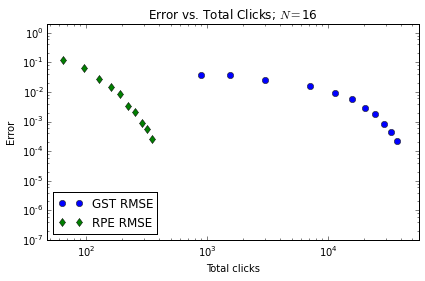

In [8]:
#Plot Figure 5.

for N in [16]:
    for angle in ['alpha']:
        method = 'GST'
        expKey = ('method',method,'N',N)
        RMSdataGSTalpha = np.sqrt(np.mean(np.abs(trueD[angle] - resultsGSTD[(angle,)+expKey][:,:,0])**2,axis=1))
        plt.plot(N*np.array(numStrsD['GST']),RMSdataGSTalpha,'o',label='GST RMSE')
        method = 'RPE'
        expKey = ('method',method,'N',N)
        RMSdataRPEalpha = np.sqrt(np.mean(resultsD[(angle,)+expKey][:,:,0]**2,axis=1))
        plt.plot(N/3.*np.array(numStrsD['RPE']),RMSdataRPEalpha,'d',label='RPE RMSE')

        plt.xlim(.5*N*np.array(numStrsD['RPE'])[0],1.5*N*np.array(numStrsD['GST'])[-1])

        plt.ylim(1e-7,2e0)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlabel('Total clicks')
        plt.ylabel('Error')
        plt.title(r'Error vs. Total Clicks; $N=$'+str(N))
        plt.legend(loc='lower left')
        plt.tight_layout()
        plt.show()

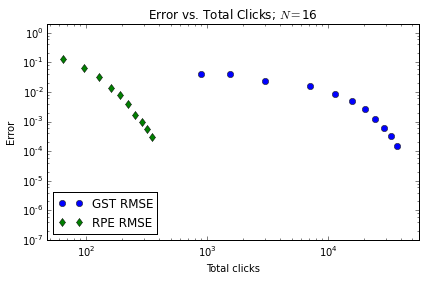

In [9]:
#Plot Supplemental Information Figure 2.

for N in [16]:
    for angle in ['epsilon']:
        method = 'GST'
        expKey = ('method',method,'N',N)
        RMSdataGSTepsilon = np.sqrt(np.mean(np.abs(trueD[angle] - resultsGSTD[(angle,)+expKey][:,:,0])**2,axis=1))
        plt.plot(N*np.array(numStrsD['GST']),RMSdataGSTepsilon,'o',label='GST RMSE')
        method = 'RPE'
        expKey = ('method',method,'N',N)
        RMSdataRPEepsilon = np.sqrt(np.mean(resultsD[(angle,)+expKey][:,:,0]**2,axis=1))
        plt.plot(N/3.*np.array(numStrsD['RPE']),RMSdataRPEepsilon,'d',label='RPE RMSE')

        plt.xlim(.5*N*np.array(numStrsD['RPE'])[0],1.5*N*np.array(numStrsD['GST'])[-1])

        plt.ylim(1e-7,2e0)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlabel('Total clicks')
        plt.ylabel('Error')
        plt.title(r'Error vs. Total Clicks; $N=$'+str(N))
        plt.legend(loc='lower left')
        plt.tight_layout()
        plt.show()

In [10]:
#Now let's print the data plotted above.

In [11]:
N=16
print('Total clicks \t RPE alpha RMSE')
for i in xrange(11):
    print(N/3.*np.array(numStrsD['RPE'])[i],'\t\t',RMSdataRPEalpha[i])

Total clicks 	 RPE alpha RMSE
32.0 		 0.215599224273
64.0 		 0.12350177335
96.0 		 0.0635575060913
128.0 		 0.0280204128289
160.0 		 0.0143311703483
192.0 		 0.00836008590527
224.0 		 0.00336304843287
256.0 		 0.0020923670161
288.0 		 0.000881568411366
320.0 		 0.000558595698295
352.0 		 0.000257028532063


In [12]:
N=16
print('Total clicks \t GST alpha RMSE')
for i in xrange(11):
    print(N*np.array(numStrsD['GST'])[i],'\t\t',RMSdataGSTalpha[i])

Total clicks 	 GST alpha RMSE
896 		 0.0377878901891
1536 		 0.0377878959434
3024 		 0.0255093842244
7088 		 0.0159434347895
11440 		 0.00939217039868
15792 		 0.00580814936587
20144 		 0.00294448279745
24496 		 0.00175640470504
28848 		 0.000828309738621
33200 		 0.000441373633933
37552 		 0.000224809323604


In [13]:
N=16
print('Total clicks \t RPE epsilon RMSE')
for i in xrange(11):
    print(N/3.*np.array(numStrsD['RPE'])[i],'\t\t',RMSdataRPEepsilon[i])

Total clicks 	 RPE epsilon RMSE
32.0 		 0.253618685703
64.0 		 0.128295155971
96.0 		 0.061871000736
128.0 		 0.0330666768265
160.0 		 0.0136522945144
192.0 		 0.007720718018
224.0 		 0.00394418786672
256.0 		 0.00171344405254
288.0 		 0.000979269466937
320.0 		 0.000548175270237
352.0 		 0.000293763407584


In [14]:
N=16
print('Total clicks \t GST epsilon RMSE')
for i in xrange(11):
    print(N*np.array(numStrsD['GST'])[i],'\t\t',RMSdataGSTepsilon[i])

Total clicks 	 GST epsilon RMSE
896 		 0.0396958485656
1536 		 0.0396957527003
3024 		 0.0240713934329
7088 		 0.0161585587228
11440 		 0.00832310831767
15792 		 0.00488422050726
20144 		 0.00273848693268
24496 		 0.00122060292109
28848 		 0.000605109369288
33200 		 0.000323582731658
37552 		 0.00015360835939
